# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Homework #3
**Harvard University**<br/>
**Spring 2018**<br/>
**Instructors: Rahul Dave**<br/>
**Due Date: ** Friday, Febrary 16th, 2018 at 10:00am

**Instructions:**

- Upload your final answers as an iPython notebook containing all of your work to Canvas.

- Structure your notebook and your work to maximize readability.

Name: Christopher Hase

In [56]:
import numpy as np
import pandas as pd
import time
from matplotlib import pyplot as plt
import torch
import torchvision
from torch.autograd import Variable
import sklearn.metrics
import os

## Problem 1: Optimization via Descent

Suppose you are building a pricing model for laying down telecom cables over a geographical region. Your model takes as input a pair of  coordinates, $(x, y)$, and contains two parameters, $\lambda_1, \lambda_2$. Given a coordinate, $(x, y)$, and model parameters, the loss in revenue corresponding to the price model at location $(x, y)$ is described by
$$
L(x, y, \lambda_1, \lambda_2) = 0.000045\lambda_2^2 y - 0.000098\lambda_1^2 x + 0.003926\lambda_1 x\exp\left\{\left(y^2 - x^2\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}
$$
Read the data contained in `HW3_data.csv`. This is a set of coordinates configured on the curve $y^2 - x^2 = -0.1$. Given the data, find parameters $\lambda_1, \lambda_2$ that minimize the net loss over the entire dataset.

### Part A
- Visually verify that for $\lambda_1 = 2.05384, \lambda_2 = 0$, the loss function $L$ is minimized for the given data.
- Implement gradient descent for minimizing $L$ for the given data, using the learning rate of 0.001.
- Implement stochastic gradient descent for minimizing $L$ for the given data, using the learning rate of 0.001.

### Part B
- Compare the average time it takes to update the parameter estimation in each iteration of the two implementations. Which method is faster? Briefly explain why this result should be expected.
- Compare the number of iterations it takes for each algorithm to obtain an estimate accurate to `1e-3` (you may wish to set a cap for maximum number of iterations). Which method converges to the optimal point in fewer iterations? Briefly explain why this result should be expected.

### Part C
Compare the performance of stochastic gradient descent for the following learning rates: 1, 0.1, 0.001, 0.0001. Based on your observations, briefly describe the effect of the choice of learning rate on the performance of the algorithm.

In [33]:
# function to compute loss
def loss(x, y, lam1, lam2):
    return 0.000045 * lam2**2 * y - 0.000098 * lam1**2 * x + 0.003926 * lam1 * x * np.exp((y**2 - x**2) * (lam1**2 + lam2**2))

# function to compute derivative of loss with respect to lam1
def derivative_loss_lam1(x, y, lam1, lam2):
    return -0.000196 * lam1 * x + x * (0.003926 - 0.007852 * lam1**2 * (x**2 - y**2)) * np.exp((y**2 - x**2) * (lam1**2 + lam2**2))

# function to compute derivative of loss with respect to lam2
def derivative_loss_lam2(x, y, lam1, lam2):
    return 0.00009 * lam2 * y - 0.007852 * lam1 * lam2 * x * (x**2 - y**2) * np.exp((y**2 - x**2) * (lam1**2 + lam2**2))

In [34]:
# read in and manipulate data
hw3_data = pd.read_csv('HW3_data.csv', header = None)
hw3_data = hw3_data.transpose()
hw3_data.columns = ['x', 'y']

Part A, visual verification

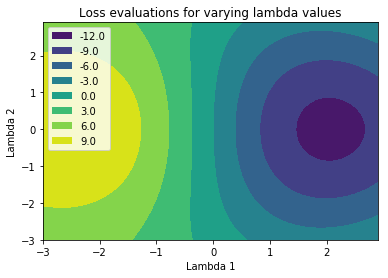

In [200]:
lam1 = np.arange(-3, 3, 0.1) # lam1 values for loss eval
lam2 = np.arange(-3, 3, 0.1) # lam2 values for loss eval
loss_evals = np.zeros((len(lam1), len(lam2))) # to store net loss values

for i in range(len(lam1)):
    for j in range(len(lam2)):
        loss_evals[j, i] = np.sum(loss(hw3_data['x'].values, hw3_data['y'].values, lam1[i], lam2[j]))
        
contour = plt.contourf(lam1, lam2, loss_evals) # contour plot

# help from: https://stackoverflow.com/questions/10490302/how-do-you-create-a-legend-for-a-contour-plot-in-matplotlib for contour plotting
proxy = [plt.Rectangle((0,0),1,1, fc = pc.get_facecolor()[0]) for pc in contour.collections]
plt.legend(proxy, list(map(str, contour.levels)), loc = 'upper left')
plt.xlabel('Lambda 1')
plt.ylabel('Lambda 2')
plt.title('Loss evaluations for varying lambda values')
plt.show()

Parts A and B, gradient descent

In [179]:
np.random.seed(1)

# initializing lam1 and lam2
lam1 = np.random.uniform(0, 1, 1)
lam2 = np.random.uniform(0, 1, 1)

lr = 0.001 # learning rate

loss_current = 0

times = []
num_iter = 0
num_iter_to_tol = 0

# stop updating lambdas when loss 'barely' changes
while abs(loss_current - np.sum(loss(hw3_data['x'].values, hw3_data['y'].values, lam1, lam2))) > 0.0000001:
    loss_current = np.sum(loss(hw3_data['x'].values, hw3_data['y'].values, lam1, lam2))
    num_iter += 1
    
    time1 = time.time()
    
    lam1 -= lr * np.sum(derivative_loss_lam1(hw3_data['x'].values, hw3_data['y'].values, lam1, lam2)) # update lam1
    lam2 -= lr * np.sum(derivative_loss_lam2(hw3_data['x'].values, hw3_data['y'].values, lam1, lam2)) # update lam2
    
    time2 = time.time()
    times.append(time2 - time1)
    
    if abs(lam1 - 2.05384) > 0.001 or abs(lam2 - 0) > 0.001: # condition indicating accuracy of estimates not within 1e-3
        num_iter_to_tol = num_iter + 1
            
    
print('Lambda 1: ' + str(lam1[0]))
print('Lambda 2: ' + str(lam2[0]))
print('Net loss: ' + str(np.sum(loss(hw3_data['x'].values, hw3_data['y'].values, lam1, lam2))))
print('Average number of seconds per iteration (gradient descent): ' + str(np.mean(times)))
print('Number of iterations to obtain estimates accurate to 1e-3 (gradient descent): ' + str(num_iter_to_tol))

Lambda 1: 2.05381089612
Lambda 2: 0.00389615269683
Net loss: -9.93408463088
Average number of seconds per iteration (gradient descent): 0.00070003604799
Number of iterations to obtain estimates accurate to 1e-3 (gradient descent): 2123


Parts A and B, stochastic gradient descent

In [178]:
np.random.seed(1)

# initializing lam1 and lam2
lam1 = np.random.uniform(0, 1, 1)
lam2 = np.random.uniform(0, 1, 1)

lr = 0.001 # learning rate

loss_current = 0
row = 0

times = []
num_iter = 0
num_iter_to_tol = 0

# stop updating lambdas when loss 'barely' changes
while abs(loss_current - np.sum(loss(hw3_data['x'].values, hw3_data['y'].values, lam1, lam2))) > 0.0000001:
    loss_current = np.sum(loss(hw3_data['x'].values, hw3_data['y'].values, lam1, lam2))
    num_iter += 1
    
    time1 = time.time()
    
    lam1 += lr * len(hw3_data) * derivative_loss_lam1(hw3_data['x'].values[row], hw3_data['y'].values[row], lam1, lam2) # update lam1
    lam2 += lr * len(hw3_data) * derivative_loss_lam2(hw3_data['x'].values[row], hw3_data['y'].values[row], lam1, lam2) # update lam2
    
    time2 = time.time()
    times.append(time2 - time1)
    
    if abs(lam1 - 2.05384) > 0.001 or abs(lam2 - 0) > 0.001: # condition indicating accuracy of estimates not within 1e-3
        num_iter_to_tol = num_iter + 1
            
    row += 1
    if row == len(hw3_data): # condition indicating end of dataset; need to reset
        row = 0
        
print('Lambda 1: ' + str(lam1[0]))
print('Lambda 2: ' + str(lam2[0]))
print('Net loss: ' + str(np.sum(loss(hw3_data['x'].values, hw3_data['y'].values, lam1, lam2))))
print('Average number of seconds per iteration (stochastic gradient descent): ' + str(np.mean(times)))
print('Number of iterations to obtain estimates accurate to 1e-3 (stochastic gradient descent): ' + str(num_iter_to_tol))

Lambda 1: 2.05384427299
Lambda 2: 1.04305347641e-30
Net loss: -9.9341040252
Average number of seconds per iteration (stochastic gradient descent): 7.23557812827e-05
Number of iterations to obtain estimates accurate to 1e-3 (stochastic gradient descent): 52


The parameter updates occur faster when using stochastic gradient descent than when using gradient descent. This is because with stochastic gradient descent, only 1 data point is being used to compute the gradient whereas with gradient descent, the entire dataset a being used to compute the gradient. 

We see convergence to the optimal point occur with fewer iterations when using stochastic gradient descent than when using gradient descent. This is because...

Part C

In [180]:
np.random.seed(1)

lrs = [1, 0.1, 0.001, 0.0001] # different learning rates
max_iter = 70 # maximum number of iterations

for lr in lrs:
    
    # initializing lam1 and lam2
    lam1 = np.random.uniform(0, 1, 1)
    lam2 = np.random.uniform(0, 1, 1)

    loss_current = 0
    row = 0

    times = []
    num_iter = 0
    num_iter_to_tol = 0
    
    # stop updating lambdas when loss 'barely' changes
    while abs(loss_current - np.sum(loss(hw3_data['x'].values, hw3_data['y'].values, lam1, lam2))) > 0.0000001:
        loss_current = np.sum(loss(hw3_data['x'].values, hw3_data['y'].values, lam1, lam2))
        num_iter += 1
        
        time1 = time.time()

        lam1 += lr * len(hw3_data) * derivative_loss_lam1(hw3_data['x'].values[row], hw3_data['y'].values[row], lam1, lam2) # update lam1
        lam2 += lr * len(hw3_data) * derivative_loss_lam2(hw3_data['x'].values[row], hw3_data['y'].values[row], lam1, lam2) # update lam2

        time2 = time.time()
        times.append(time2 - time1)

        if abs(lam1 - 2.05384) > 0.001 or abs(lam2 - 0) > 0.001: # condition indicating accuracy of estimates not within 1e-3
            num_iter_to_tol = num_iter + 1

        row += 1
        if row == len(hw3_data): # condition indicating end of dataset; need to reset
            row = 0
            
        if num_iter == max_iter: # condition indication we reached max number of iterations
            num_iter_to_tol = 'Did not converge'
            break

    print('Learning rate: ' + str(lr))
    print('Lambda 1: ' + str(lam1[0]))
    print('Lambda 2: ' + str(lam2[0]))
    print('Net loss: ' + str(np.sum(loss(hw3_data['x'].values, hw3_data['y'].values, lam1, lam2))))
    print('Average number of seconds per iteration (stochastic gradient descent): ' + str(np.mean(times)))
    print('Number of iterations to obtain estimates accurate to 1e-3 (stochastic gradient descent): ' + str(num_iter_to_tol))
    print()

Learning rate: 1
Lambda 1: -5.69411873177e+148
Lambda 2: -1.64132647247e+124
Net loss: 6.47495320745e+296
Average number of seconds per iteration (stochastic gradient descent): 7.15562275478e-05
Number of iterations to obtain estimates accurate to 1e-3 (stochastic gradient descent): Did not converge

Learning rate: 0.1
Lambda 1: 5.21486958304e+74
Lambda 2: 2.13438348492e+53
Net loss: 5.43088367249e+148
Average number of seconds per iteration (stochastic gradient descent): 4.29732458932e-05
Number of iterations to obtain estimates accurate to 1e-3 (stochastic gradient descent): Did not converge

Learning rate: 0.001
Lambda 1: 2.05384426876
Lambda 2: 9.5721794651e-32
Net loss: -9.9341040252
Average number of seconds per iteration (stochastic gradient descent): 3.58053616115e-05
Number of iterations to obtain estimates accurate to 1e-3 (stochastic gradient descent): 52

Learning rate: 0.0001
Lambda 1: 2.05384832172
Lambda 2: 0.00130741942505
Net loss: -9.93410184176
Average number of seco

With learning rates that are too high (1 and 0.1), convergence to the optimal point does not occur. When using a learning rate of 0.0001, the number of iterations it takes to obtain estimates accurate to 1e-3 is higher than when using a learning rate of 0.001.

## Problem 2. SGD for Multinomial Logistic Regression on MNIST

The [*MNIST* dataset](https://en.wikipedia.org/wiki/MNIST_database) is one of the classic datasets in Machine Learning and is often one of the first datasets against which new classification algorithms test themselves.  It consists of 70,000 images of handwritten digits, each of which is 28x28 pixels. You will be using PyTorch to build a handwritten digit classifier that you will train and test with MNIST. 

** The MNIST dataset (including a train/test split which you must use) is part of PyTorch in the torchvision module.  The Lab will have details of how to load it. **

Your classifier must implement a multinomial logistic regression model (using softmax). It will take as input an array of pixel values in an image and output the images most likely digit label (i.e. 0-9). You should think of the pixel values as features of the input vector.  

1. Plot 10 sample images from the MNIST dataset (to develop intuition for the feature space).
2. Construct a softmax formulation in PyTorch of multinomial logistic regression with Cross Entropy Loss.
3. Train your model using SGD to minimize the cost function. *Use a batch size of 64, a learning rate $\eta = 0.01$, and 10 epochs*.
4. Plot the cross-entropy loss on the training set as a function of iteration.
5. What are the training and test set accuracies?  
6. Plot some (around 5) examples of misclassifications.




In [2]:
# help from: https://gist.github.com/xmfbit/b27cdbff68870418bdb8cefa86a2d558 for data loading
# load in MNIST
train = torchvision.datasets.MNIST(root = os.getcwd(), train=True, transform=torchvision.transforms.ToTensor(), download = True)
test = torchvision.datasets.MNIST(root = os.getcwd(), train=False, transform=torchvision.transforms.ToTensor(), download = True)

# create batches
batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset = train, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test, batch_size = batch_size, shuffle=False)

Part 1

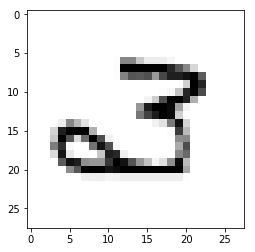

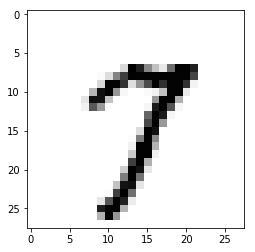

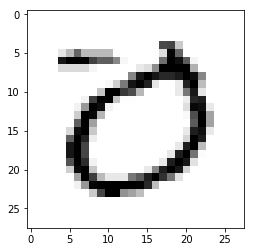

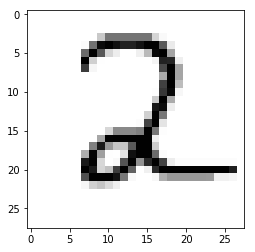

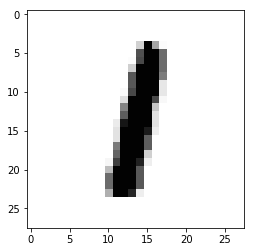

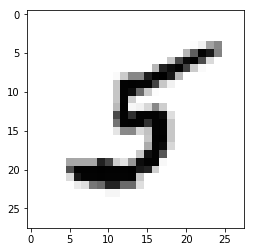

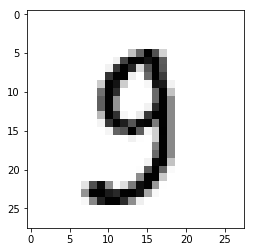

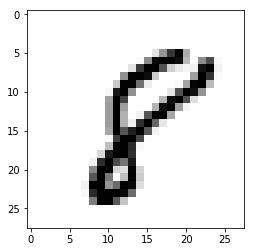

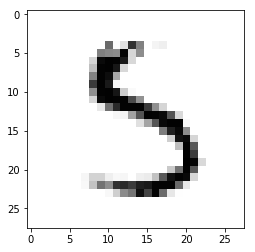

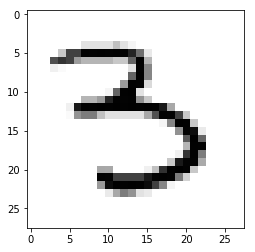

In [3]:
np.random.seed(10)
img_samples = np.random.choice(np.arange(60000), 10) # randomly sample images

# plot 10 random images
for img in img_samples:
    plt.imshow(train[img][0][0].numpy(), cmap = 'Greys')
    plt.show()

Parts 2 and 3

In [91]:
multiclass_logit = torch.nn.Linear(in_features = 28*28, out_features = 10, bias = True) # linear layer
loss_function = torch.nn.CrossEntropyLoss() # cross entropy loss function
optimizer = torch.optim.SGD(multiclass_logit.parameters(), lr = 0.01) # SGD optimizer
num_epochs = 10

training_batch_losses = []
for epoch in range(num_epochs):
    
    num_batches = 0
    epoch_loss = 0
    for batch in train_loader:
        model_output = multiclass_logit(Variable(torch.squeeze(batch[0], 1).view(len(batch[0]), 28*28))) # model predictions
        targets = Variable(batch[1]) # true digit values
        
        optimizer.zero_grad() # zero gradient
        loss_batch = loss_function(model_output, targets) # compute loss
        loss_batch.backward() # take the gradient wrt parameters
        optimizer.step() # update parameters
        
        epoch_loss += loss_batch.data[0]
        num_batches += 1
        training_batch_losses.append(loss_batch.data[0])

Part 4

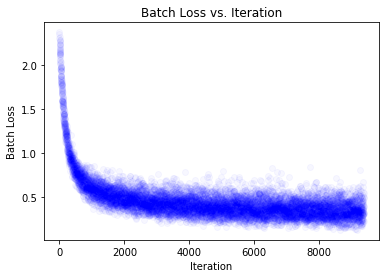

In [99]:
plt.plot(np.arange(len(training_batch_losses)), training_batch_losses, 'bo', alpha = 0.03)
plt.xlabel('Iteration')
plt.ylabel('Batch Loss')
plt.title('Batch Loss vs. Iteration')
plt.show()

Part 5

In [115]:
softmax = torch.nn.Softmax() # softmax to compute output probabilities 

# compute train accuracy
train_model_pred = []
train_targets = []
for batch in train_loader:
    model_output = multiclass_logit(Variable(torch.squeeze(batch[0], 1).view(len(batch[0]), 28*28))) # output from linear layer
    model_probs = softmax(model_output).data.numpy() # digit probabilities
    train_model_pred += np.argmax(model_probs, axis = 1).tolist() # digit predictions
    train_targets += batch[1].numpy().tolist() # true digit values
      
# compute test accuracy
test_model_pred = []
test_targets = []
for batch in test_loader:
    model_output = multiclass_logit(Variable(torch.squeeze(batch[0], 1).view(len(batch[0]), 28*28))) # output from linear layer
    model_probs = softmax(model_output).data.numpy() # digit probabilities
    test_model_pred += np.argmax(model_probs, axis = 1).tolist() # digit predictions
    test_targets += batch[1].numpy().tolist() # true digit values
    

print('Train accuracy: ' + str(sklearn.metrics.accuracy_score(train_targets, train_model_pred)))    
print('Test accuracy: ' + str(sklearn.metrics.accuracy_score(test_targets, test_model_pred)))

Train accuracy: 0.90345
Test accuracy: 0.9085


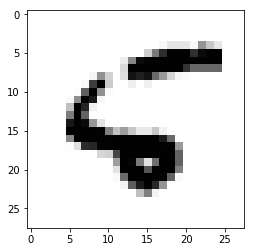

Predicted digit: 6
Actual digit: 5




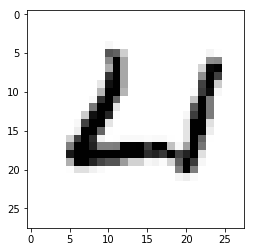

Predicted digit: 6
Actual digit: 4




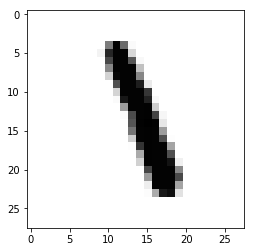

Predicted digit: 3
Actual digit: 1




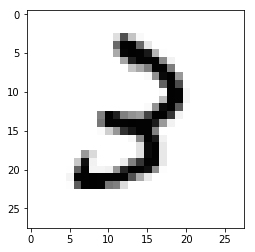

Predicted digit: 2
Actual digit: 3




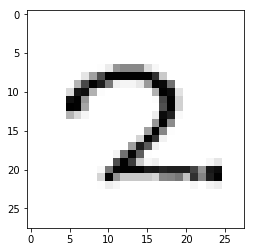

Predicted digit: 7
Actual digit: 2




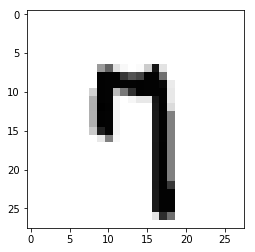

Predicted digit: 9
Actual digit: 7




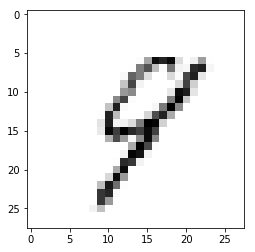

Predicted digit: 4
Actual digit: 9




In [116]:
num_incorrect = 0
for batch in test_loader:
    model_output = multiclass_logit(Variable(torch.squeeze(batch[0], 1).view(len(batch[0]), 28*28))) # output from linear layer
    model_probs = softmax(model_output).data.numpy() # digit probabilities
    test_model_pred = np.argmax(model_probs, axis = 1).tolist() # digit predictions
    test_targets = batch[1].numpy().tolist() # true digit values
     
    for i in range(len(test_model_pred)):
        if test_model_pred[i] != test_targets[i]: # if prediction incorrect then plot
            plt.imshow(batch[0][i][0].numpy(), cmap = 'Greys')
            plt.show()
            print('Predicted digit: ' + str(test_model_pred[i]))
            print('Actual digit: ' + str(test_targets[i]))
            print()
            print()
            num_incorrect += 1
            
            if num_incorrect == 7: # find 7 misclassifications
                break
    
    if num_incorrect == 7: # find 7 misclassifications
        break